# Building NARX Neural Network using Sysidentpy

Example created by Wilson Rocha Lacerda Junior

## Series-Parallel Training and Parallel prediction

Currently *SysIdentPy* support a Series-Parallel (open-loop) Feedforward Network training
process, which make the training process easier. We convert the NARX network from Series-Parallel to the Parallel (closed-loop) configuration for prediction. 

Series-Parallel allows us to use Pytorch directly for training, so we can use all the power of the Pytorch library to build our NARX Neural Network model! 

![](figures/narxnet.png)

The reader is referred to the following paper for a more in depth discussion about Series-Parallel and Parallel configurations regarding NARX neural network:

[Parallel Training Considered Harmful?: Comparing series-parallel and parallel feedforward
network training](https://arxiv.org/pdf/1706.07119.pdf)


## Building a NARX Neural Network

First, just import the necessary packages

In [ ]:
pip install sysidentpy

In [1]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.narmax_tools import regressor_code
import torch

In [2]:
torch.cuda.is_available()

False

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Getting the data

The data is generated by simulating the following model:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$.

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$,

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.1$

In [4]:
x_train, x_valid, y_train, y_valid = get_siso_data(
    n=1000, colored_noise=False, sigma=0.01, train_percentage=80
)

## Choosing the NARX parameters, loss function and optimizer

One can create a NARXNN object and choose the maximum lag of both input and output for building the regressor matrix to serve as input of the network.

In addition, you can choose the loss function, the optimizer, the optional parameters of the optimizer, the number of epochs.

Because we built this feature on top of Pytorch, you can choose any of the loss function of the torch.nn.functional. [Click here](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) for a list of the loss functions you can use. You just need to pass the name of the loss function you want.

Similarly, you can choose any of the optimizers of the torch.optim. [Click here](https://pytorch.org/docs/stable/optim.html) for a list of optimizers available.



In [5]:
basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    epochs=2000,
    verbose=False,
    device="cuda",
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    },  # optional parameters of the optimizer
)

C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\neural_network\narx_nn.py:156: UserWarning: No CUDA available. We set the device as CPU
  self.device = self._check_cuda(device)


Since we have defined our NARXNN using $ylag=2$, $xlag=2$ and a polynomial basis function with $degree=1$, we have a regressor matrix with 4 features. We need the size of the regressor matrix to build the layers of our network. Our input data(x_train) have only one feature, but since we are creating an NARX network, a regressor matrix is built behind the scenes with new features based on the xlag and ylag.

If you need help finding how many regressors are created behind the scenes you can use the narmax_tools function regressor_code and take the size of the regressor code generated:

In [6]:
basis_function = Polynomial(degree=1)

regressors = regressor_code(
    X=x_train,
    xlag=2,
    ylag=2,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function,
)

In [7]:
n_features = regressors.shape[0]  # the number of features of the NARX net
n_features

4

In [8]:
regressors

array([[1001],
       [1002],
       [2001],
       [2002]])

## Building the NARX Neural Network

The configuration of your network follows exactly the same pattern of a network defined in Pytorch. The following representing our NARX neural network.

In [9]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(n_features, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin3 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

We have to pass the defined network to our NARXNN estimator.

In [10]:
narx_net.net = NARX()

In [11]:
if device == "cuda":
    narx_net.net.to(torch.device("cuda"))

## Fit and Predict

Because we have a fit (for training) and predict function for Polynomial NARMAX, we create the same pattern for the NARX net. So, you only have to fit and predict using the following:

In [12]:
narx_net.fit(X=x_train, y=y_train, X_test=x_valid, y_test=y_valid)

In [13]:
yhat = narx_net.predict(X=x_valid, y=y_valid)

## Results

Now we show the results

MSE:  0.00013103585914746256


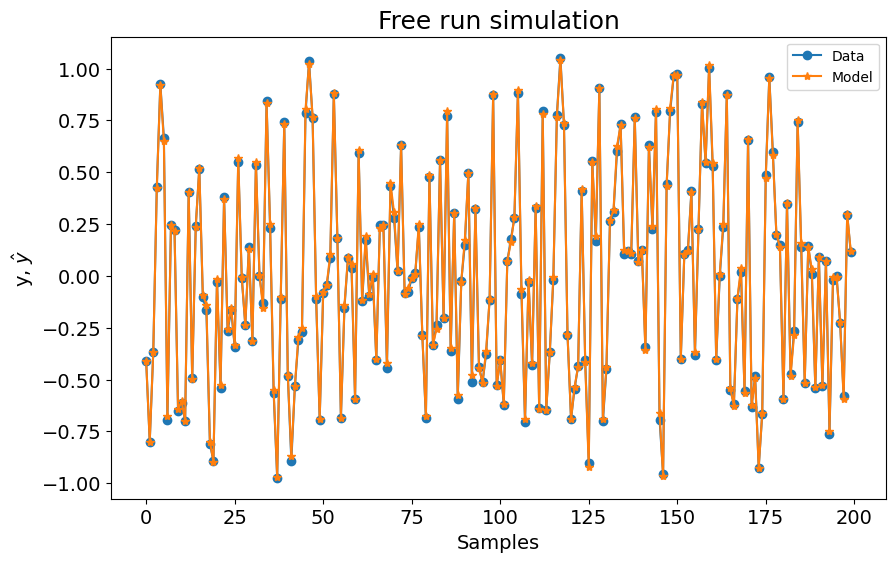

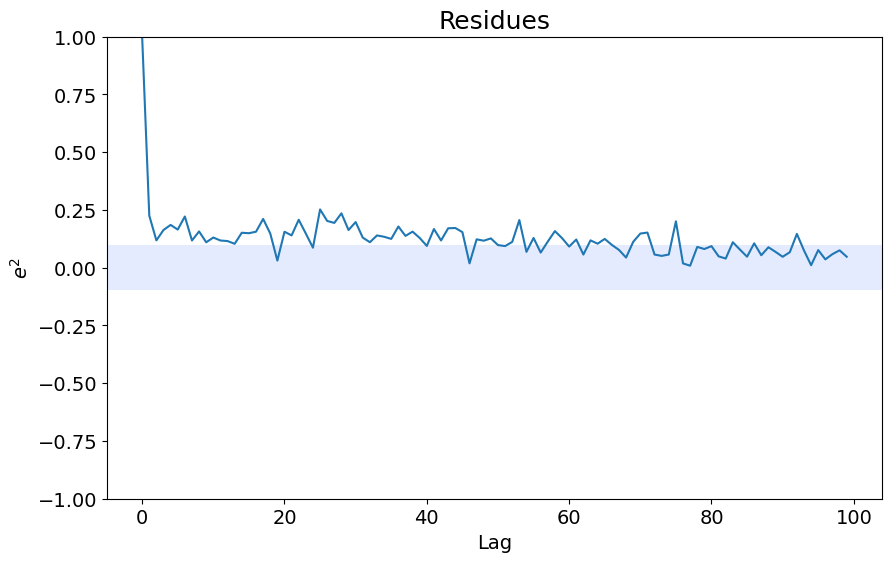

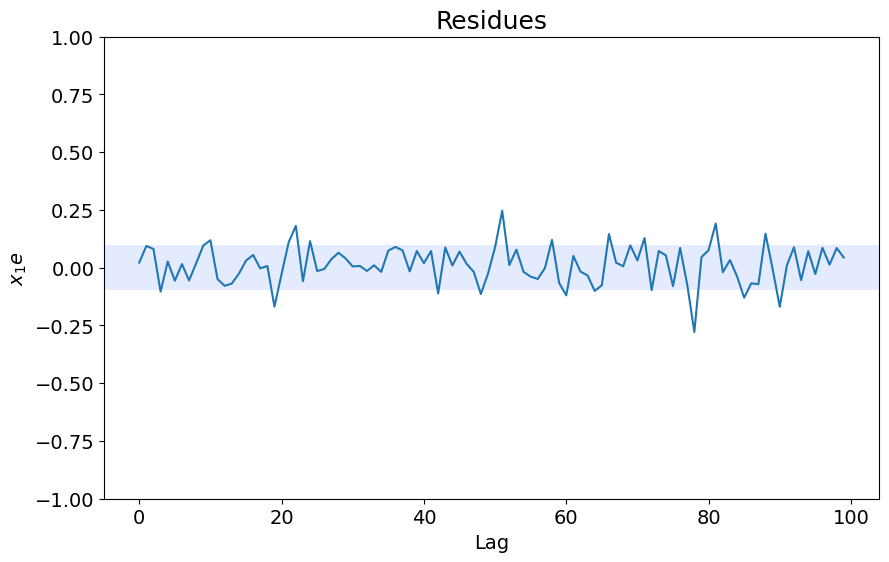

In [14]:
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

## Note

If you built the net configuration before calling the NARXNN, you can just pass the model to the NARXNN as follows:

MSE:  0.00010086796658327408


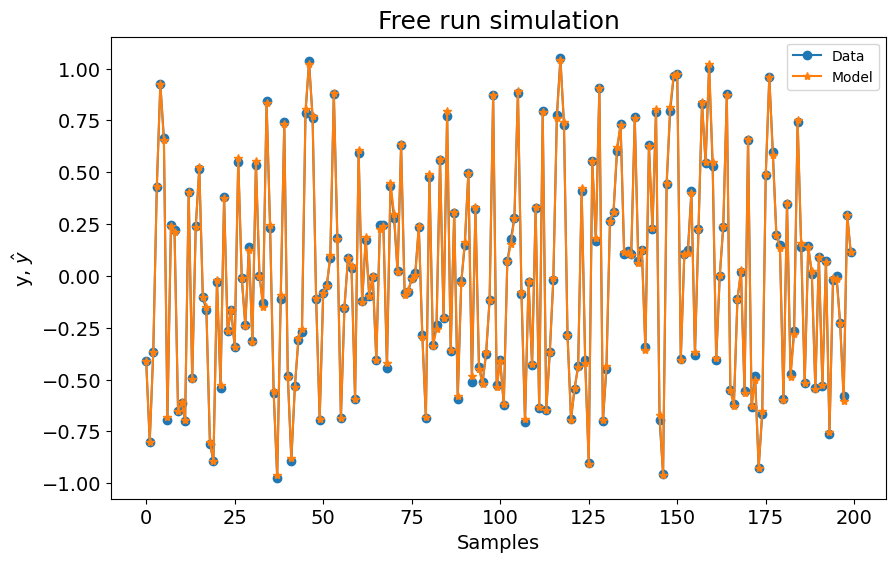

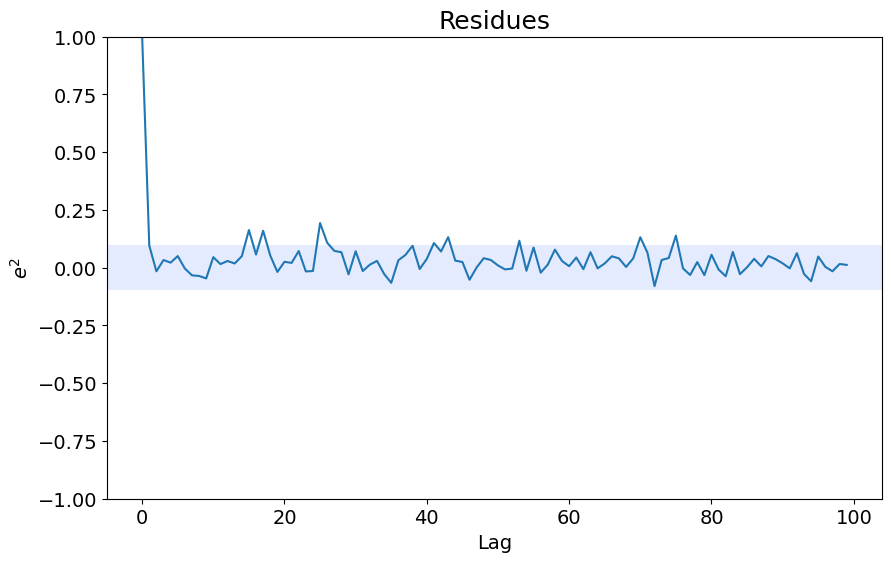

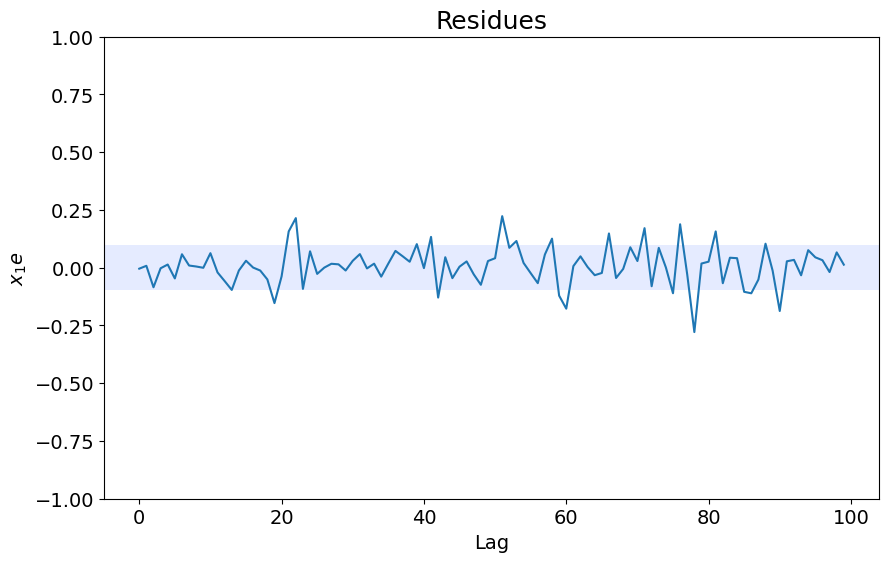

In [15]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(n_features, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin3 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z


narx_net2 = NARXNN(
    net=NARX(),
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    epochs=2000,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    },  # optional parameters of the optimizer
)

narx_net2.fit(X=x_train, y=y_train)
yhat = narx_net2.predict(X=x_valid, y=y_valid)
print("MSE: ", mean_squared_error(y_valid, yhat))

plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

# Note

Remember you can use n-steps-ahead prediction and NAR and NFIR models. Check how to use it in their respective examples.